#  Project group 30 
## Image colorization by combining semantic segmentation and autoencoding 

Install dependencies

In [1]:
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize
from torch import nn, optim
import torchvision.transforms
from torchvision.transforms import Compose

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

# !pip install kornia
import kornia
from PIL import Image, ImageOps 

import glob
import os

Path

In [2]:
train_path = "\Train"

val_path = "\Validation"

test_path = "\Test"

Class for creating dataloader

In [3]:
class DataLoaderSegmentationAndColorisation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentationAndColorisation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) # PIL images
            SEG = Image.open(mask_path)
        
            if self.transform is not None:
                data = self.transform(data)
                SEG = self.transform(SEG) # segmentation should probably only be resized

            # SOMETHING FISHY HERE
            #transform = transforms.Compose([ 
            #    transforms.PILToTensor() 
            #]) 

            #img_lab = kornia.color.rgb_to_lab(transform(data))
            SEG = np.array(SEG)
            np.moveaxis(SEG, 0, -1).shape
            SEG = torch.from_numpy(SEG).float()
        
            img_rgb = np.array(data)
            np.moveaxis(img_rgb, 0, -1).shape
            img_rgb = torch.from_numpy(img_rgb).float()
            img_rgb = img_rgb/255
            img_lab = kornia.color.rgb_to_lab(img_rgb.permute(2, 0, 1))

            L = (img_lab.permute(1, 2, 0))[:,:,0]
            A = (img_lab.permute(1, 2, 0))[:,:,1]
            B = (img_lab.permute(1, 2, 0))[:,:,2]
        
            input = torch.stack((L,SEG))
            output = torch.stack((A,B))
            
            # data = [L, SEG] label = [A, B]
            input = input.to(torch.float32) 
            output = output.to(torch.float32)       
            return input, output

    def __len__(self):
        return len(self.img_files)


Creating dataloaders

In [4]:
batch_size = 16
img_size = 256 

train_transforms = Compose([Resize((img_size,img_size), antialias=True)])

example_transform = Compose([Resize((img_size,img_size), antialias=True)])
example_dataset = DataLoaderSegmentationAndColorisation(train_path,example_transform)

input, output = example_dataset[30]

#print(input.shape)
#print(output.shape)

train_set = DataLoaderSegmentationAndColorisation(train_path, train_transforms)
val_set = DataLoaderSegmentationAndColorisation(val_path, train_transforms)


train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Defining network structure

In [5]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs) 
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

    
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(2, 64) # Maybe 2 since L and SEG
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, 2, kernel_size=1, padding=0) # 2 since A and B
    def forward(self, inputs):
        """ Encoder """
        #print(inputs.shape)
        #inputs = inputs.permute(1,0,2,3)
        inputs = torch.squeeze(inputs)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

Training loop

In [6]:
#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#cmap = get_cmap(n_classes)

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        # Validate fucks up
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Val. loss: {val_loss:.3f}, ")
        train_losses.extend(train_loss)
        val_losses.append(val_loss)

        file_name = 'loss_color_seg.txt'
        with open(file_name, "a") as file:
            file.write(f"Train loss epoch: {sum(train_loss)/len(train_loss):.3f}, Val. loss epoch: {val_loss:.3f}\n")
        
        # Save model to disk after each epoch
        torch.save(model.state_dict(), 'segmentation_and_color_model.pth')
        
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):    
        inputs, labels = x.to(device), y.to(device)
        inputs = inputs[None, :]
        
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        print(f"\tBatch {batch_index}/{num_batches}")
        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, ")

            file_name = 'loss_color_seg.txt'
            with open(file_name, "a") as file:
                file.write(f"Train loss batch: {sum(train_loss_batches[-print_every:])/print_every:.3f}, Val. loss batch: {val_loss:.3f}\n")
    
    return model, train_loss_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            inputs = inputs[None, :]
            
            z = model.forward(inputs)
            z = torch.round(z)
            #batch_loss = loss_fn(z, labels.long()) 
            batch_loss = loss_fn(z, labels) 
            val_loss_cum += batch_loss.item()      
            
            # Visual test
            if batch_index == 1:          
                A_output = z[0,0,:,:].to(device)
                B_output = z[0,1,:,:].to(device)

                inputs = torch.squeeze(inputs)
                
                L_true = inputs[0,0,:,:] # [128, 128] [img, img]
                A_true = labels[0,0,:,:] # [128, 128] [img, img]
                B_true = labels[0,1,:,:] # [128, 128] [img, img]

                output_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
                target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)
                
                f, axarr = plt.subplots(1,4)
                axarr[0].imshow(L_true,'grey')         # L input
                axarr[1].imshow(inputs[0,1,:,:])     # SEG input
                axarr[2].imshow(output_img) # Output picture (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
                axarr[3].imshow(target_img) # Facit picture

                plt.show()
                # Save the model each time we plot (REMOVE LATER)
                torch.save(model.state_dict(), 'segmentation_and_color_model.pth')

    return val_loss_cum/len(val_loader)

Training 

Reading model from disk
Continue writing to loss textfile
Starting training
	Batch 1/125
	Batch 2/125
	Batch 3/125
	Batch 4/125
	Batch 5/125
	Batch 6/125
	Batch 7/125
	Batch 8/125
	Batch 9/125
	Batch 10/125
	Batch 11/125
	Batch 12/125
	Batch 13/125
	Batch 14/125
	Batch 15/125
	Batch 16/125
	Batch 17/125
	Batch 18/125
	Batch 19/125
	Batch 20/125
	Batch 21/125
	Batch 22/125
	Batch 23/125
	Batch 24/125
	Batch 25/125


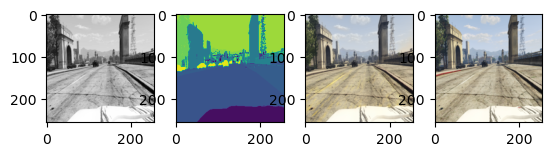

	Train loss: 22.479, 	Val. loss: 33.619, 
	Batch 26/125
	Batch 27/125
	Batch 28/125
	Batch 29/125
	Batch 30/125
	Batch 31/125
	Batch 32/125
	Batch 33/125
	Batch 34/125
	Batch 35/125
	Batch 36/125
	Batch 37/125
	Batch 38/125
	Batch 39/125
	Batch 40/125
	Batch 41/125
	Batch 42/125
	Batch 43/125
	Batch 44/125
	Batch 45/125
	Batch 46/125
	Batch 47/125
	Batch 48/125
	Batch 49/125
	Batch 50/125


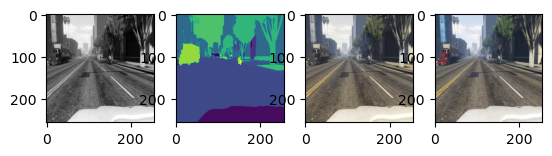

	Train loss: 20.895, 	Val. loss: 26.230, 
	Batch 51/125
	Batch 52/125
	Batch 53/125
	Batch 54/125
	Batch 55/125
	Batch 56/125
	Batch 57/125
	Batch 58/125
	Batch 59/125
	Batch 60/125
	Batch 61/125
	Batch 62/125
	Batch 63/125
	Batch 64/125
	Batch 65/125
	Batch 66/125
	Batch 67/125
	Batch 68/125
	Batch 69/125
	Batch 70/125
	Batch 71/125
	Batch 72/125
	Batch 73/125
	Batch 74/125
	Batch 75/125


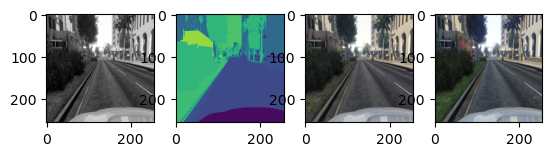

	Train loss: 20.491, 	Val. loss: 21.053, 
	Batch 76/125
	Batch 77/125
	Batch 78/125
	Batch 79/125
	Batch 80/125
	Batch 81/125
	Batch 82/125
	Batch 83/125
	Batch 84/125
	Batch 85/125
	Batch 86/125
	Batch 87/125
	Batch 88/125
	Batch 89/125
	Batch 90/125
	Batch 91/125
	Batch 92/125
	Batch 93/125
	Batch 94/125
	Batch 95/125
	Batch 96/125
	Batch 97/125
	Batch 98/125
	Batch 99/125
	Batch 100/125


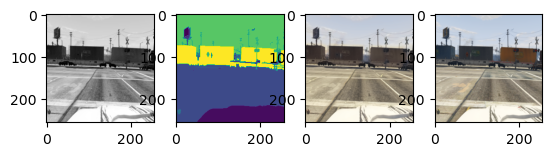

	Train loss: 22.247, 	Val. loss: 22.153, 
	Batch 101/125
	Batch 102/125
	Batch 103/125
	Batch 104/125
	Batch 105/125
	Batch 106/125
	Batch 107/125
	Batch 108/125
	Batch 109/125
	Batch 110/125
	Batch 111/125
	Batch 112/125
	Batch 113/125
	Batch 114/125
	Batch 115/125
	Batch 116/125
	Batch 117/125
	Batch 118/125
	Batch 119/125
	Batch 120/125
	Batch 121/125
	Batch 122/125
	Batch 123/125
	Batch 124/125
	Batch 125/125


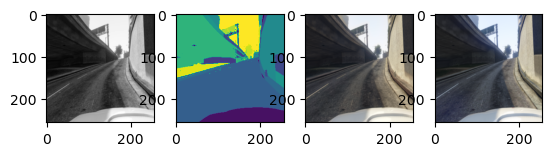

	Train loss: 21.083, 	Val. loss: 25.732, 


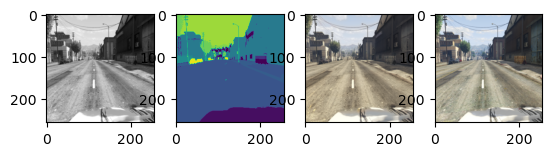

Epoch 1/4: Train loss: 21.439, Val. loss: 26.263, 
	Batch 1/125
	Batch 2/125
	Batch 3/125
	Batch 4/125
	Batch 5/125
	Batch 6/125
	Batch 7/125
	Batch 8/125
	Batch 9/125
	Batch 10/125
	Batch 11/125
	Batch 12/125
	Batch 13/125
	Batch 14/125
	Batch 15/125
	Batch 16/125
	Batch 17/125
	Batch 18/125
	Batch 19/125
	Batch 20/125
	Batch 21/125
	Batch 22/125
	Batch 23/125
	Batch 24/125
	Batch 25/125


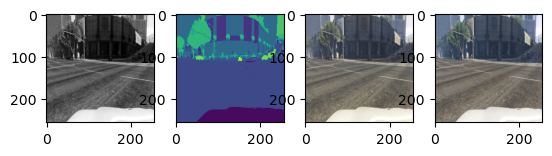

	Train loss: 20.474, 	Val. loss: 19.201, 
	Batch 26/125
	Batch 27/125
	Batch 28/125
	Batch 29/125
	Batch 30/125
	Batch 31/125
	Batch 32/125
	Batch 33/125
	Batch 34/125
	Batch 35/125
	Batch 36/125
	Batch 37/125
	Batch 38/125
	Batch 39/125
	Batch 40/125
	Batch 41/125
	Batch 42/125
	Batch 43/125
	Batch 44/125
	Batch 45/125
	Batch 46/125
	Batch 47/125
	Batch 48/125
	Batch 49/125
	Batch 50/125


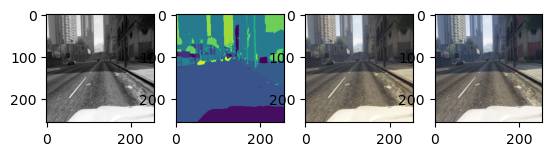

	Train loss: 20.539, 	Val. loss: 25.728, 
	Batch 51/125
	Batch 52/125
	Batch 53/125
	Batch 54/125
	Batch 55/125
	Batch 56/125
	Batch 57/125
	Batch 58/125
	Batch 59/125
	Batch 60/125
	Batch 61/125
	Batch 62/125
	Batch 63/125
	Batch 64/125
	Batch 65/125
	Batch 66/125
	Batch 67/125
	Batch 68/125
	Batch 69/125
	Batch 70/125
	Batch 71/125
	Batch 72/125
	Batch 73/125
	Batch 74/125
	Batch 75/125


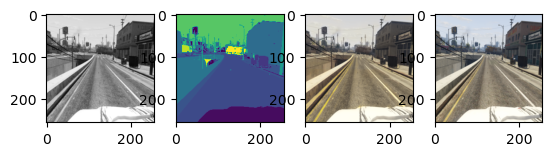

	Train loss: 21.399, 	Val. loss: 35.706, 
	Batch 76/125
	Batch 77/125
	Batch 78/125
	Batch 79/125
	Batch 80/125
	Batch 81/125
	Batch 82/125
	Batch 83/125
	Batch 84/125
	Batch 85/125
	Batch 86/125
	Batch 87/125
	Batch 88/125
	Batch 89/125
	Batch 90/125
	Batch 91/125
	Batch 92/125
	Batch 93/125
	Batch 94/125
	Batch 95/125
	Batch 96/125
	Batch 97/125
	Batch 98/125
	Batch 99/125
	Batch 100/125


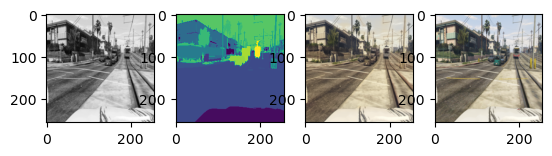

	Train loss: 22.934, 	Val. loss: 48.265, 
	Batch 101/125
	Batch 102/125
	Batch 103/125
	Batch 104/125
	Batch 105/125
	Batch 106/125
	Batch 107/125
	Batch 108/125
	Batch 109/125
	Batch 110/125
	Batch 111/125
	Batch 112/125
	Batch 113/125
	Batch 114/125
	Batch 115/125
	Batch 116/125
	Batch 117/125
	Batch 118/125
	Batch 119/125
	Batch 120/125
	Batch 121/125
	Batch 122/125
	Batch 123/125
	Batch 124/125
	Batch 125/125


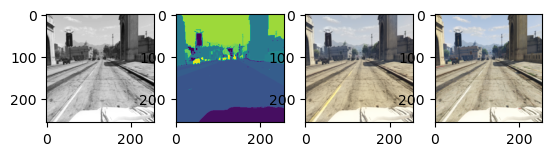

	Train loss: 24.090, 	Val. loss: 22.635, 


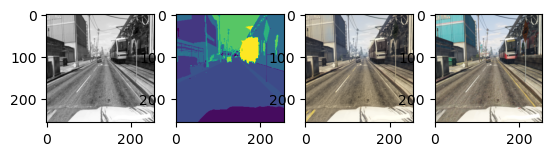

Epoch 2/4: Train loss: 21.887, Val. loss: 22.472, 
	Batch 1/125
	Batch 2/125
	Batch 3/125
	Batch 4/125
	Batch 5/125
	Batch 6/125
	Batch 7/125
	Batch 8/125
	Batch 9/125
	Batch 10/125
	Batch 11/125
	Batch 12/125
	Batch 13/125
	Batch 14/125
	Batch 15/125
	Batch 16/125
	Batch 17/125
	Batch 18/125
	Batch 19/125
	Batch 20/125
	Batch 21/125
	Batch 22/125
	Batch 23/125
	Batch 24/125
	Batch 25/125


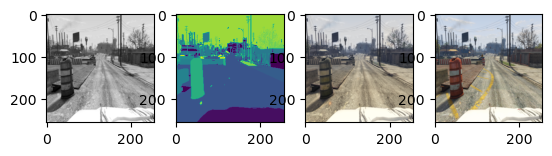

	Train loss: 24.110, 	Val. loss: 22.428, 
	Batch 26/125
	Batch 27/125
	Batch 28/125
	Batch 29/125
	Batch 30/125
	Batch 31/125
	Batch 32/125
	Batch 33/125
	Batch 34/125
	Batch 35/125
	Batch 36/125
	Batch 37/125
	Batch 38/125
	Batch 39/125
	Batch 40/125
	Batch 41/125
	Batch 42/125
	Batch 43/125
	Batch 44/125
	Batch 45/125
	Batch 46/125
	Batch 47/125
	Batch 48/125
	Batch 49/125
	Batch 50/125


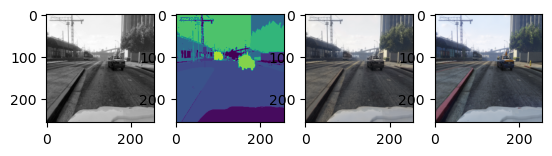

	Train loss: 21.068, 	Val. loss: 29.602, 
	Batch 51/125
	Batch 52/125
	Batch 53/125
	Batch 54/125
	Batch 55/125
	Batch 56/125
	Batch 57/125
	Batch 58/125
	Batch 59/125
	Batch 60/125
	Batch 61/125
	Batch 62/125
	Batch 63/125
	Batch 64/125
	Batch 65/125
	Batch 66/125
	Batch 67/125
	Batch 68/125
	Batch 69/125
	Batch 70/125
	Batch 71/125
	Batch 72/125
	Batch 73/125
	Batch 74/125
	Batch 75/125


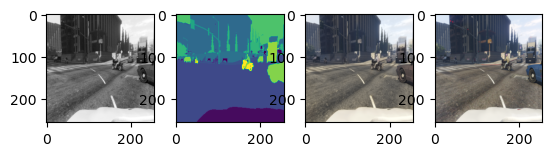

	Train loss: 19.809, 	Val. loss: 20.024, 
	Batch 76/125
	Batch 77/125
	Batch 78/125
	Batch 79/125
	Batch 80/125
	Batch 81/125
	Batch 82/125
	Batch 83/125
	Batch 84/125
	Batch 85/125
	Batch 86/125
	Batch 87/125
	Batch 88/125
	Batch 89/125
	Batch 90/125
	Batch 91/125
	Batch 92/125
	Batch 93/125
	Batch 94/125
	Batch 95/125
	Batch 96/125
	Batch 97/125
	Batch 98/125
	Batch 99/125
	Batch 100/125


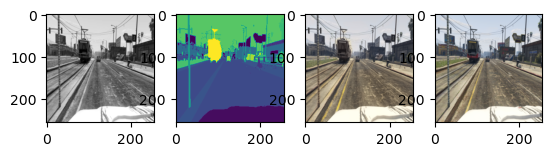

	Train loss: 22.286, 	Val. loss: 22.130, 
	Batch 101/125
	Batch 102/125
	Batch 103/125
	Batch 104/125
	Batch 105/125
	Batch 106/125
	Batch 107/125
	Batch 108/125
	Batch 109/125
	Batch 110/125
	Batch 111/125
	Batch 112/125
	Batch 113/125
	Batch 114/125
	Batch 115/125
	Batch 116/125
	Batch 117/125
	Batch 118/125
	Batch 119/125
	Batch 120/125
	Batch 121/125
	Batch 122/125
	Batch 123/125
	Batch 124/125
	Batch 125/125


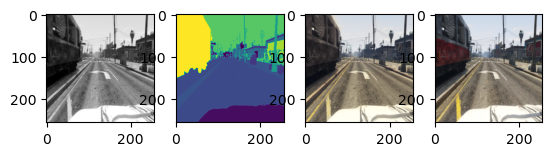

	Train loss: 20.250, 	Val. loss: 20.028, 


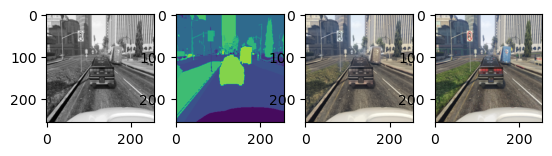

Epoch 3/4: Train loss: 21.504, Val. loss: 19.860, 
	Batch 1/125
	Batch 2/125
	Batch 3/125
	Batch 4/125
	Batch 5/125
	Batch 6/125
	Batch 7/125
	Batch 8/125
	Batch 9/125
	Batch 10/125
	Batch 11/125
	Batch 12/125
	Batch 13/125
	Batch 14/125
	Batch 15/125
	Batch 16/125
	Batch 17/125
	Batch 18/125
	Batch 19/125
	Batch 20/125
	Batch 21/125
	Batch 22/125
	Batch 23/125
	Batch 24/125
	Batch 25/125


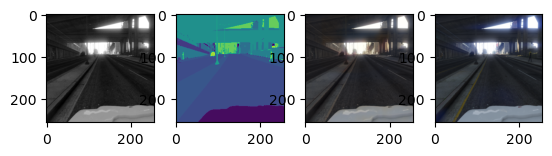

	Train loss: 20.025, 	Val. loss: 25.365, 
	Batch 26/125
	Batch 27/125
	Batch 28/125
	Batch 29/125
	Batch 30/125
	Batch 31/125
	Batch 32/125
	Batch 33/125
	Batch 34/125
	Batch 35/125
	Batch 36/125
	Batch 37/125
	Batch 38/125
	Batch 39/125
	Batch 40/125
	Batch 41/125
	Batch 42/125
	Batch 43/125
	Batch 44/125
	Batch 45/125
	Batch 46/125
	Batch 47/125
	Batch 48/125
	Batch 49/125
	Batch 50/125


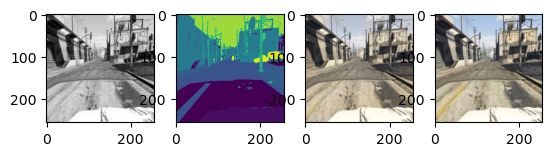

	Train loss: 20.034, 	Val. loss: 28.393, 
	Batch 51/125
	Batch 52/125
	Batch 53/125
	Batch 54/125
	Batch 55/125
	Batch 56/125
	Batch 57/125
	Batch 58/125
	Batch 59/125
	Batch 60/125
	Batch 61/125
	Batch 62/125
	Batch 63/125
	Batch 64/125
	Batch 65/125
	Batch 66/125
	Batch 67/125
	Batch 68/125
	Batch 69/125
	Batch 70/125
	Batch 71/125
	Batch 72/125
	Batch 73/125
	Batch 74/125
	Batch 75/125


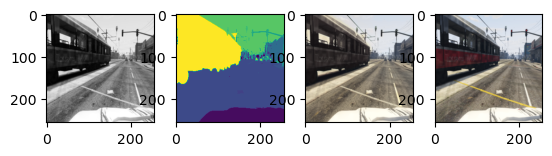

	Train loss: 20.371, 	Val. loss: 20.731, 
	Batch 76/125
	Batch 77/125
	Batch 78/125
	Batch 79/125
	Batch 80/125
	Batch 81/125
	Batch 82/125
	Batch 83/125
	Batch 84/125
	Batch 85/125
	Batch 86/125
	Batch 87/125
	Batch 88/125
	Batch 89/125
	Batch 90/125
	Batch 91/125
	Batch 92/125
	Batch 93/125
	Batch 94/125
	Batch 95/125
	Batch 96/125
	Batch 97/125
	Batch 98/125
	Batch 99/125
	Batch 100/125


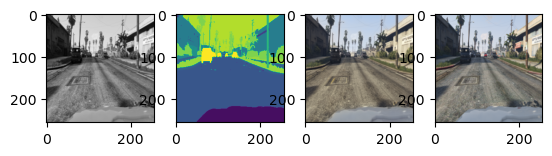

	Train loss: 20.357, 	Val. loss: 21.418, 
	Batch 101/125
	Batch 102/125
	Batch 103/125
	Batch 104/125
	Batch 105/125
	Batch 106/125
	Batch 107/125
	Batch 108/125
	Batch 109/125
	Batch 110/125
	Batch 111/125
	Batch 112/125
	Batch 113/125
	Batch 114/125
	Batch 115/125
	Batch 116/125
	Batch 117/125
	Batch 118/125
	Batch 119/125
	Batch 120/125
	Batch 121/125
	Batch 122/125
	Batch 123/125
	Batch 124/125
	Batch 125/125


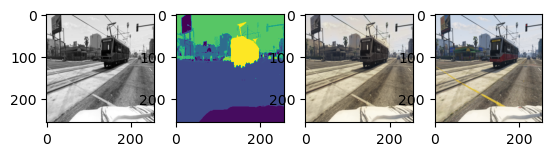

	Train loss: 20.102, 	Val. loss: 31.866, 


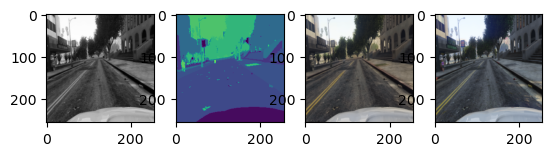

Epoch 4/4: Train loss: 20.178, Val. loss: 31.485, 


In [7]:
train_from_disk = True

if train_from_disk:  
    # Read model from disk
    print("Reading model from disk")
    pretrained = torch.load('segmentation_and_color_model.pth', map_location=lambda storage, loc: storage)
    Segmentaion_and_color_model = build_unet()
    Segmentaion_and_color_model.load_state_dict(torch.load('segmentation_and_color_model.pth'))
    print("Continue writing to loss textfile")
    file_name = 'loss_color_seg.txt'
    with open(file_name, "a") as file:
        file.write('Continue:\n')
else:
    # Create new model
    print("Creating new model")
    Segmentaion_and_color_model = build_unet()
    print("Starting over writing to loss textfile")
    file_name = 'loss_color_seg.txt'
    with open(file_name, "w") as file:
        file.write('Losses:\n')

optimizer = optim.Adam(Segmentaion_and_color_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss() # kass som faen men int nu
#loss_fn = nn.CrossEntropyLoss() # mindre kass
train_loader = train_dataloader 
val_loader = val_dataloader
num_epochs = 4
print_every = 25

Segmentaion_and_color_model, Segmentaion_and_color_train_losses, Segmentaion_and_color_val_losses = training_loop(Segmentaion_and_color_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)
